In [1]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fashionmnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240512%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240512T085736Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D668b928255d3625fe06d8854c31f81b4652dbf215b9801d763c2ecadf3cd062265f30a717ee2416c6012d2158b9085816b5ee306f80e01170387d8b07e21303f4765e327065b2eea08e94220892855c2e5b7b5e29f0714a0db208fbe0236f580bead631822a16078ed97e78e8994a67d3524837704e376342d394b45db83e5ef125b3cbd6dbbe1017357a48dd4792c405f65fbe9bb86a60fb5fba792010ee9005cad3322cd70ca2ca025cdfd3f70b1dd32a30233d787352259c2844ebfe3ca3b91bd772b227e29c2b5ce91309d06efc643b55a8b0675640cee0e6bc5f159e7ea939e8017ebffa81933dff289ef7febc1332df61c43dffb9502d6586fb793561f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 72114846 bytes downloaded
Downloaded and uncompressed: fashionmnist
Data source import complete.


![](http://)

In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv


**Importing useful packages**

In [3]:
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

# **Loading and Preprocessing the data**

In [4]:
train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


dropping the labels from the dataset

In [5]:
X_train = train_data.drop('label',axis=1)
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train=X_train.values
print(X_train.shape)

(60000, 784)


In [7]:
X_train=X_train.reshape(-1,28,28,1)
print(X_train.shape)

(60000, 28, 28, 1)


# **Data Visualization**

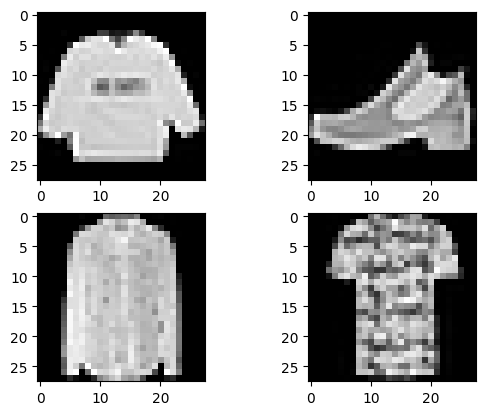

In [8]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [9]:
X_train =  X_train.astype('float32')

In [10]:
X_train = X_train/255
X_train = X_train*2 - 1.

In [11]:
print(X_train.max(),X_train.min())

1.0 -1.0


# **Simple GAN Model**

**Generative part**

In [12]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

**Discriminatory part**

In [14]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 28, 28, 1)         2         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)              

1. Compiling the discriminator layer
2. Compiling the GAN

NOTE : the generator layer is not compiled seperately because it gets trained as part of the combined model but training the discriminator is necessary because it is trained before the combined model.

In [16]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [17]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [18]:
GAN.layers

In [19]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         320656    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 242179    
                                                                 
Total params: 562835 (2.15 MB)
Trainable params: 318864 (1.22 MB)
Non-trainable params: 243971 (953.01 KB)
_________________________________________________________________


In [20]:
epochs = 30
batch_size = 100
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
1/1 [==============================] - 0s 17ms/step


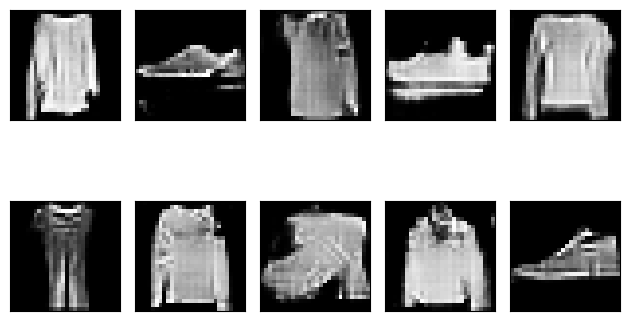

Currently on Epoch 2
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 3
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 4


In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")


    for i in range(X_train.shape[0]//batch_size):

        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")

        noise=np.random.normal(size=[batch_size,noise_shape])

        gen_image = generator.predict_on_batch(noise)

        train_dataset = X_train[i*batch_size:(i+1)*batch_size]

        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)

        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)


        #training generator
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False

        d_g_loss_batch =GAN.train_on_batch(noise, train_label)




    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()



print('Training is complete')

In [22]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

1/1 [==============================] - 0s 17ms/step


noise generated using np.random.normal is given to as input to the generator. In the next step the generator produces batches of meaningful alike image from the random distribution.

Text(0.5, 1.0, 'How the noise looks')

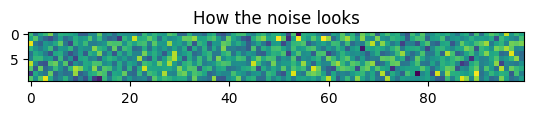

In [23]:
plt.imshow(noise)
plt.title('How the noise looks')

**Generator producing images from noise**

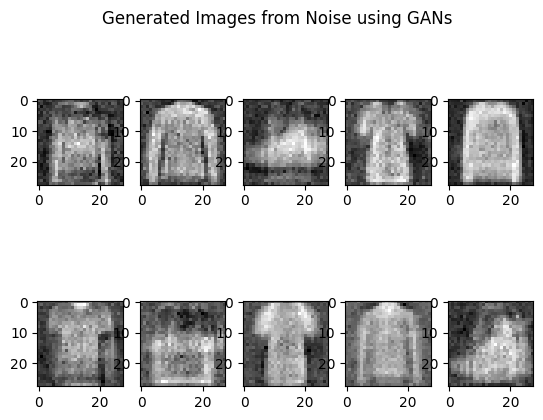

In [24]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

# **GAN using Deep Convolutions**

In [25]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[100]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [26]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                      

In [27]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [28]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [29]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [30]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [31]:
GAN.layers

In [32]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


In [33]:
epochs = 150
batch_size = 100

In [34]:
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
1/1 [==============================] - 0s 136ms/step


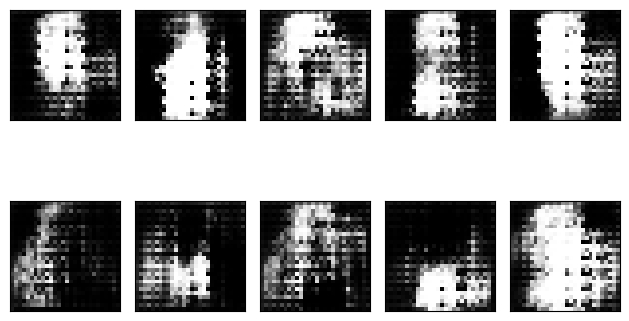

Currently on Epoch 2
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 3
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 4
	Currently on batch number 

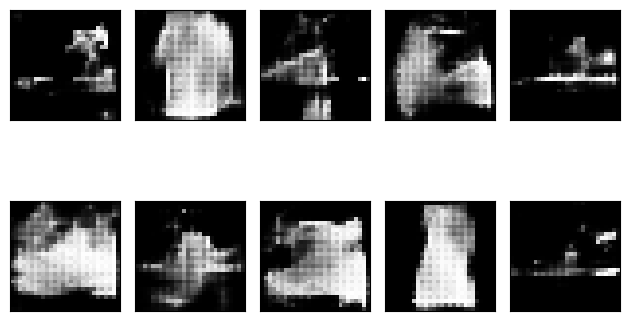

Currently on Epoch 12
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 13
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 14
	Currently on batch numb

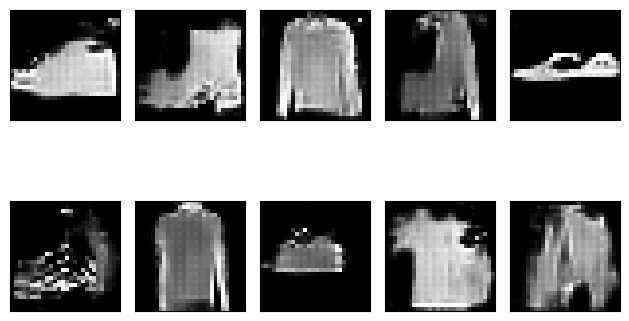

Currently on Epoch 22
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 23
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 24
	Currently on batch numb

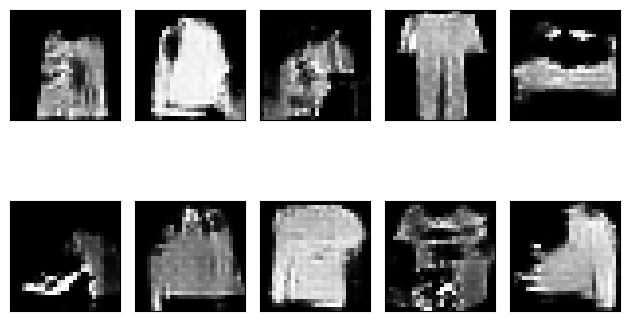

Currently on Epoch 32
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 33
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 34
	Currently on batch numb

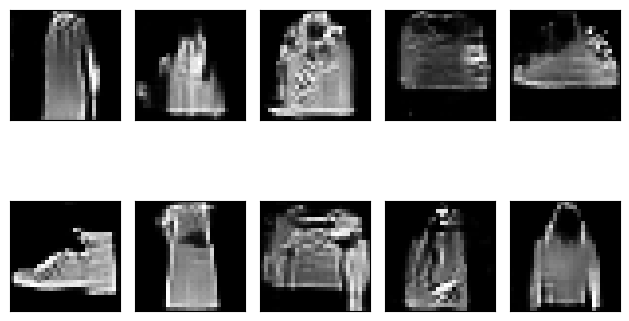

Currently on Epoch 42
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 43
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 44
	Currently on batch numb

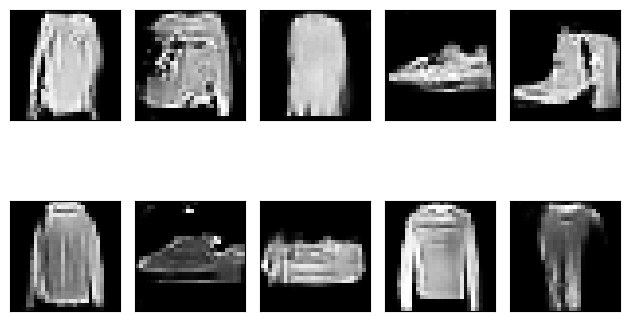

Currently on Epoch 52
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 53
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 54
	Currently on batch numb

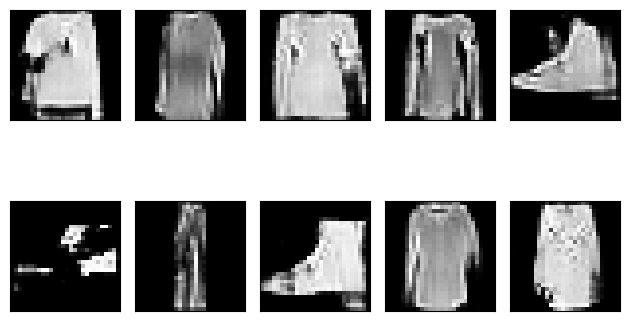

Currently on Epoch 62
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 63
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 64
	Currently on batch numb

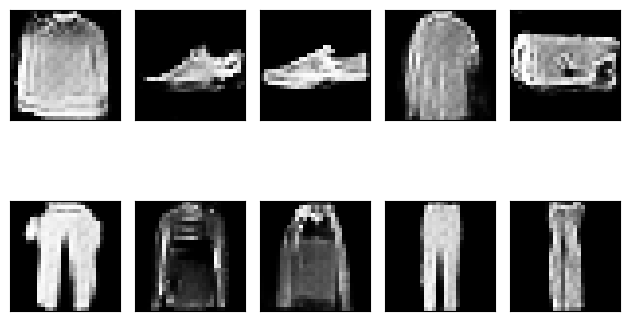

Currently on Epoch 72
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 73
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 74
	Currently on batch numb

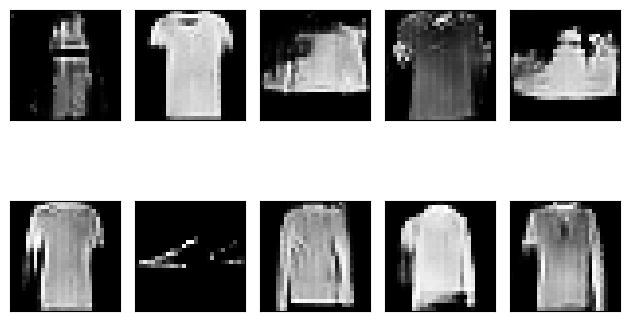

Currently on Epoch 82
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 83
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 84
	Currently on batch numb

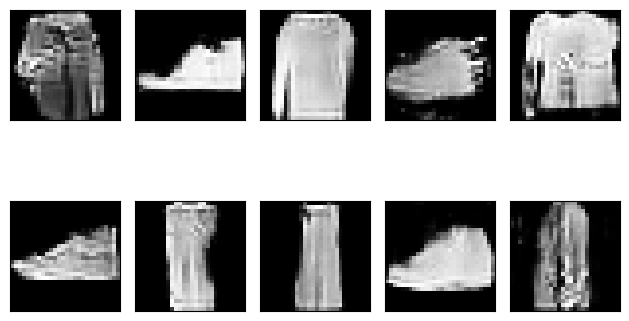

Currently on Epoch 92
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 93
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 94
	Currently on batch numb

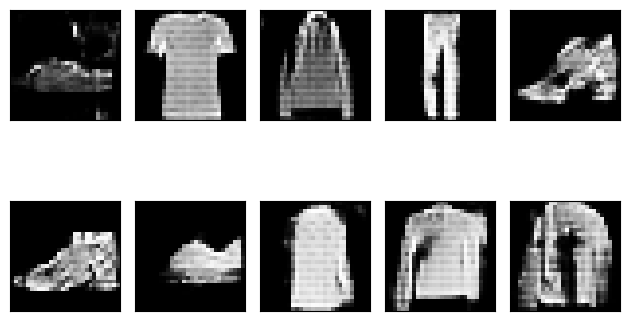

Currently on Epoch 102
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 103
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 104
	Currently on batch n

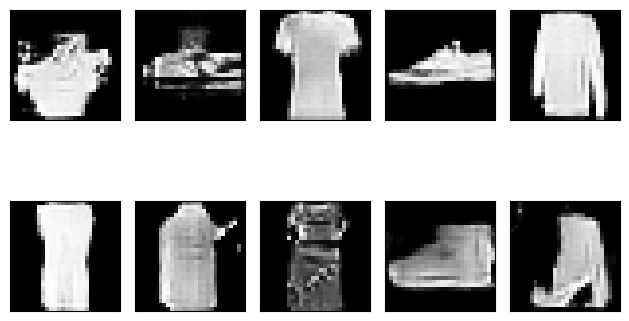

Currently on Epoch 112
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 113
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 114
	Currently on batch n

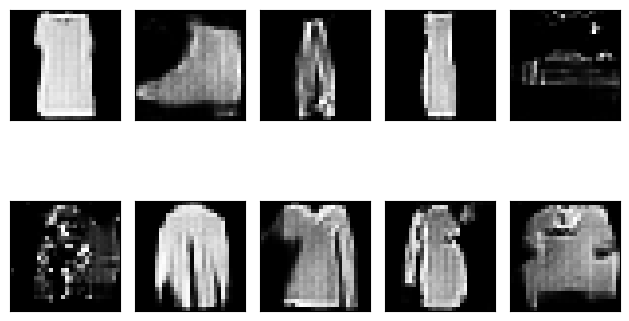

Currently on Epoch 122
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 123
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 124
	Currently on batch n

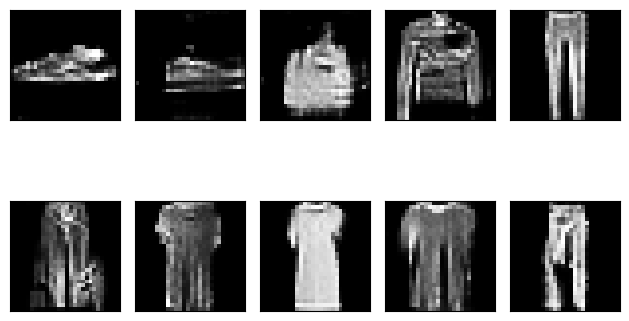

Currently on Epoch 132
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 133
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 134
	Currently on batch n

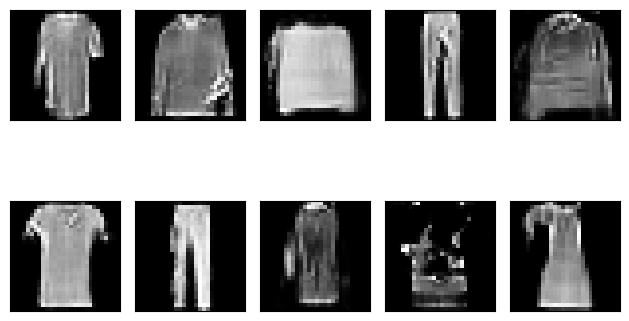

Currently on Epoch 142
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 143
	Currently on batch number 50 of 600
	Currently on batch number 100 of 600
	Currently on batch number 150 of 600
	Currently on batch number 200 of 600
	Currently on batch number 250 of 600
	Currently on batch number 300 of 600
	Currently on batch number 350 of 600
	Currently on batch number 400 of 600
	Currently on batch number 450 of 600
	Currently on batch number 500 of 600
	Currently on batch number 550 of 600
	Currently on batch number 600 of 600
Currently on Epoch 144
	Currently on batch n

In [35]:

with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")


    for i in range(X_train.shape[0]//batch_size):

        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")

        noise=np.random.normal(size=[batch_size,noise_shape])

        gen_image = generator.predict_on_batch(noise)

        train_dataset = X_train[i*batch_size:(i+1)*batch_size]

        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)

        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)


        #training generator
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False #while training the generator as combined model,discriminator training should be turned off

        d_g_loss_batch =GAN.train_on_batch(noise, train_label)




    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()



print('Training is complete')

In [36]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))

gen_image = generator.predict(noise)

4/4 [==============================] - 0s 18ms/step


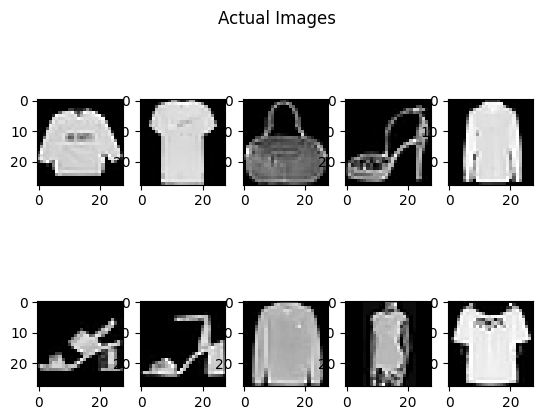

In [37]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=10

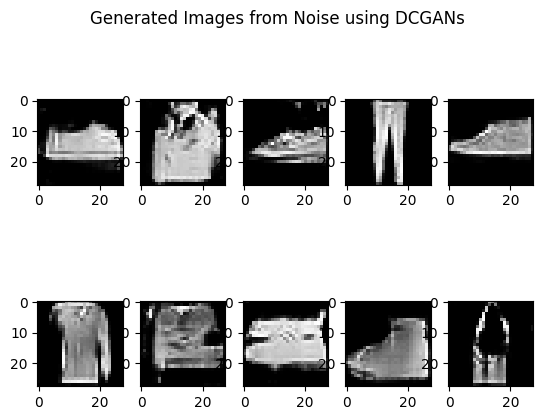

In [38]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3